In [1]:
include("src/Models.jl")
include("src/Params.jl")
include("src/Utils.jl")

using DifferentialEquations
using Plots; gr();

Intrinsic period. Given \[KaiA\] = 1.0 uM the period should solve to 23.2 hours.

In [2]:
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.0
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]
_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500, p)
Tbase

23.215001853643642

What is the perturbation?

The perturbation is assumed to be a step growth where protein is synthesized and volume expands.
Protein synthesis rate exactly matches the volume expansion rate so that the total concentration of each Kai protein stays the same.
However, only U-KaiC is assumed to be synthesized. If volume is expanded $\gamma$ compared to before,

$$
[U]_{new} = \frac{[U]_{old} + \gamma [C]_{tot}}{1 + \gamma}\\
[P]_{new} = \frac{[P]_{old}}{1 + \gamma}
$$

Where $P \in {S, T, D}$.

Assume that the total cellular volume doubles every $\tau$ hours.
We further assume that the cell, for some reason, applies the volume expansion at discrete time points.
This is a direct simulation of the robot in vitro experiment.
If the volume is expended every $t_{wait}$ hours, the expanded volume is

$$
\Delta V = V_0\left(2^{t_{wait}/\tau} - 1\right)
$$

I.e.,

$$
\gamma = 2^{t_{wait}/\tau} - 1
$$

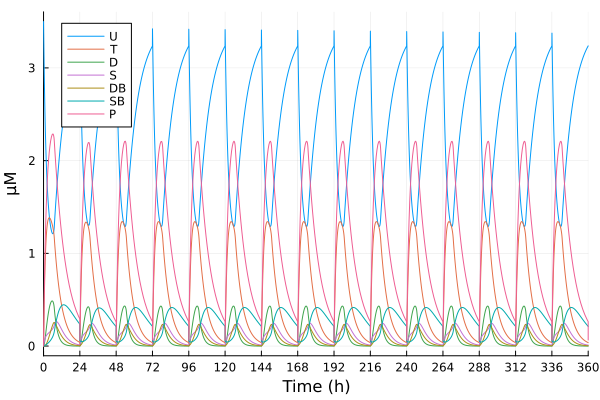

In [50]:
# Parameters
A0 = 1.0
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

tau = 12
t_wait = 24

# "Event"
function affect!(integrator)
    Ctot = sum(integrator.u)
    
    γ = 2^(t_wait/tau) - 1
    
    integrator.u[1] += γ*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + γ
end

# Initial condition
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]

TMAX = 360.0
expand_t_vec = t_wait:t_wait:TMAX

# Integration
cb = PresetTimeCallback(expand_t_vec, affect!)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, TMAX), p)
sol = solve(prob, callback=cb, reltol=1e-8, abstol=1e-8)

plot(sol, labels=["U" "T" "D" "S" "DB" "SB"])
plot!(sol.t, 3.5*phospho_C(sol.u), label="P")
xticks!(0:24:TMAX)
xlabel!("Time (h)")
ylabel!("μM")

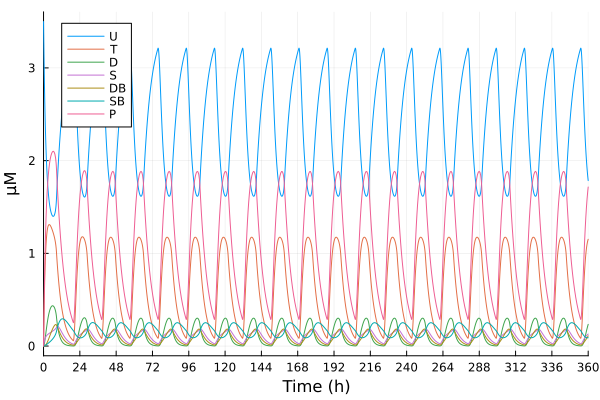

In [48]:
# The continuous model

# Initial condition
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]

# Integration
prob = ODEProblem(kaiabc_growing!, X0, (0.0, TMAX), (p..., tau, U0))
sol_con = solve(prob, reltol=1e-8, abstol=1e-8)

plot(sol_con, labels=["U" "T" "D" "S" "DB" "SB"])
plot!(sol_con.t, 3.5*phospho_C(sol_con.u), label="P")
xticks!(0:24:TMAX)
xlabel!("Time (h)")
ylabel!("μM")

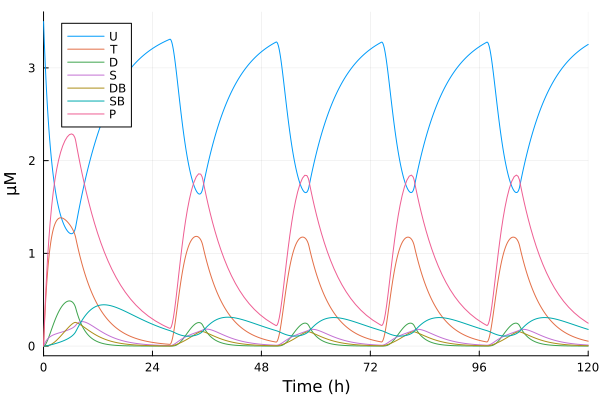

In [15]:
# The original model

# Parameters
A0 = 1.0
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

# Initial condition
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]

TMAX = 120.0

# Integration
prob = ODEProblem(kaiabc_phong!, X0, (0.0, TMAX), p)
sol_ori = solve(prob, reltol=1e-8, abstol=1e-8)

plot(sol_ori, labels=["U" "T" "D" "S" "DB" "SB"])
plot!(sol_ori.t, 3.5*phospho_C(sol_ori.u), label="P")
xticks!(0:24:TMAX)
xlabel!("Time (h)")
ylabel!("μM")

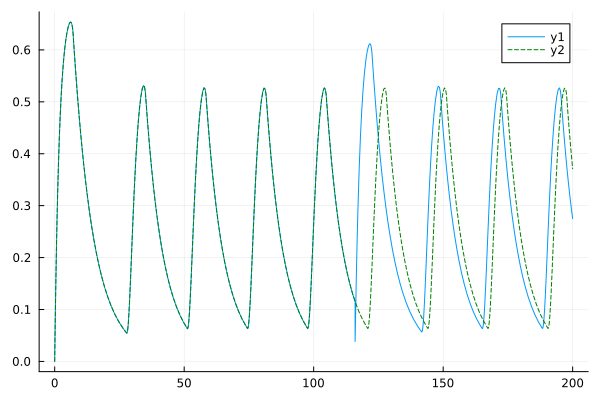

T perturb: 16 Phase shift: 0.5801656678370222


In [3]:
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]
p_ori = copy(p)

γ = 2.00    # ratio of increase in conc
tperturb = 16
tstab = 100.0    # t where perturbation is applied = tperturb + tstab

function affect!(integrator)
    Ctot = sum(integrator.u)
    integrator.u[1] += γ*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + γ
end

cb = PresetTimeCallback(tstab + tperturb, affect!)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p)
sol = solve(prob, callback=cb, reltol=1e-8, abstol=1e-8)
prob_ori = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p_ori)
sol_ori = solve(prob_ori, reltol=1e-8, abstol=1e-8)

plot(sol.t, phospho_C(sol.u))
plot!(sol_ori.t, phospho_C(sol_ori.u), color=:green, linestyle=:dash) |> display

# phase without perturbation
_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p_ori, avg_window=32)

# phase after perturbation
converge, A, T, ϕ = attracted_to(kaiabc_phong!, X0, 500.0, p, callback=cb, burnin=2*tstab, avg_window=32, conv_tol=5e-3)
    
ϕjump = mod2pi(ϕ + (tstab + tperturb)/T*2π)
ϕbase_jump = mod2pi(ϕbase + (tstab + tperturb)/Tbase*2π)
Δϕ = ϕjump - ϕbase_jump
println("T perturb: ", tperturb, " Phase shift: ", Δϕ)

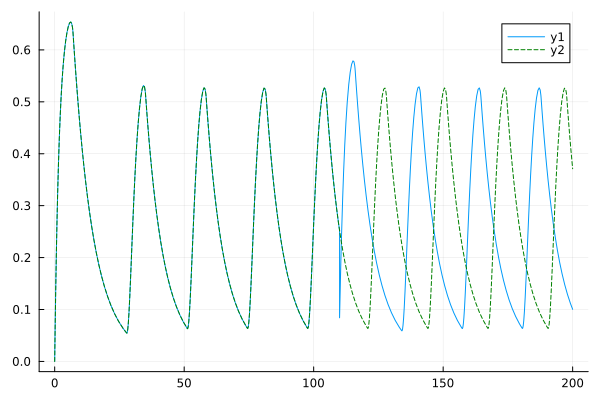

T perturb: 10 Phase shift: 2.6945839899878767


In [4]:
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]
p_ori = copy(p)

γ = 2.00    # ratio of increase in conc
tperturb = 10
tstab = 100.0    # t where perturbation is applied = tperturb + tstab

function affect!(integrator)
    Ctot = sum(integrator.u)
    integrator.u[1] += γ*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + γ
end

cb = PresetTimeCallback(tstab + tperturb, affect!)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p)
sol = solve(prob, callback=cb, reltol=1e-8, abstol=1e-8)
prob_ori = ODEProblem(kaiabc_phong!, X0, (0.0, 200.0), p_ori)
sol_ori = solve(prob_ori, reltol=1e-8, abstol=1e-8)

plot(sol.t, phospho_C(sol.u))
plot!(sol_ori.t, phospho_C(sol_ori.u), color=:green, linestyle=:dash) |> display

# phase without perturbation
_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p_ori, avg_window=32)

# phase after perturbation
converge, A, T, ϕ = attracted_to(kaiabc_phong!, X0, 500.0, p, callback=cb, burnin=2*tstab, avg_window=32, conv_tol=5e-3)
    
ϕjump = mod2pi(ϕ + (tstab + tperturb)/T*2π)
ϕbase_jump = mod2pi(ϕbase + (tstab + tperturb)/Tbase*2π)
Δϕ = ϕjump - ϕbase_jump
println("T perturb: ", tperturb, " Phase shift: ", Δϕ)

In [28]:
# params
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.5
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

γ = 0.30    # ratio of increase in conc
tstab = 100.0    # t where perturbation is applied = tperturb + tstab

# define the jump
function affect!(integrator)
    Ctot = sum(integrator.u)
    integrator.u[1] += γ*Ctot
    # normalize to enforce C-to-A ratio
    integrator.u /= 1 + γ
end

_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p, avg_window=32)
tperturb_vec = (0:1/72:1) .* Tbase
#tperturb_vec = [0.2, 1.2]*Tbase

ϕ_vec = zeros(length(tperturb_vec))

for i = 1:length(tperturb_vec)
    X0 = [U0, 0, 0, 0, 0, 0]
    # p is modified on-the-fly. has to be reset every time
    p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
         KA, A0, fATP, N, M]
    
    cb = PresetTimeCallback(tstab + tperturb_vec[i], affect!)
    converge, A, T, ϕ = attracted_to(kaiabc_phong!, X0, 500.0, p, callback=cb, burnin=2*tstab, avg_window=32, conv_tol=5e-3)
    
    ϕjump = mod2pi(ϕ + (tstab + tperturb_vec[i])/T*2π)
    ϕbase_jump = mod2pi(ϕbase + (tstab + tperturb_vec[i])/Tbase*2π)
    Δϕ = ϕjump - ϕbase_jump
    ϕ_vec[i] = Δϕ
#     println(ϕ)    # should be different
#     println(ϕjump)    # at jump, should be the same now
    println("T perturb: ", tperturb_vec[i], " Phase shift: ", Δϕ)
end

T perturb: 0.0 Phase shift: 0.6714158604323721
T perturb: 0.39295931668609496 Phase shift: 0.6692412550988465
T perturb: 0.7859186333721899 Phase shift: 0.6746976430410179
T perturb: 1.1788779500582849 Phase shift: 0.6720482100694944
T perturb: 1.5718372667443798 Phase shift: 0.6606983377565427
T perturb: 1.9647965834304748 Phase shift: 0.6724785920884813
T perturb: 2.3577559001165698 Phase shift: 0.6822253136063452
T perturb: 2.7507152168026647 Phase shift: 0.6711177761556151
T perturb: 3.1436745334887597 Phase shift: 0.6715947478614055
T perturb: 3.5366338501748547 Phase shift: 0.6718796299138603
T perturb: 3.9295931668609496 Phase shift: 0.6722435556665047
T perturb: 4.322552483547044 Phase shift: 0.6592693755941426
T perturb: 4.7155118002331395 Phase shift: 0.679541408924571
T perturb: 5.108471116919235 Phase shift: 0.6711058528610678
T perturb: 5.5014304336053295 Phase shift: 0.6723468065599398
T perturb: 5.894389750291424 Phase shift: 0.6736602460497387
T perturb: 6.2873490669775

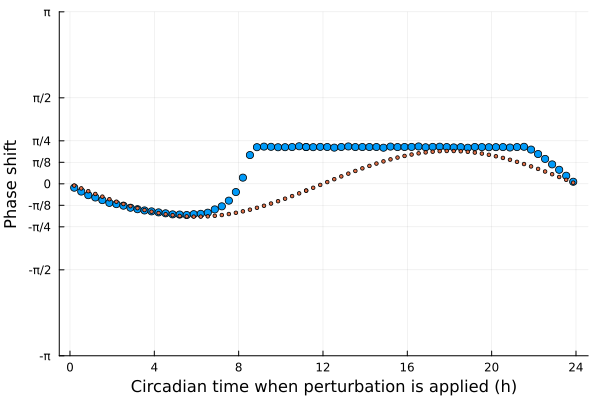

In [29]:
ϕperturb_vec = @. mod2pi(ϕbase + (tstab + tperturb_vec)/Tbase*2π)
CTperturb_vec = ϕperturb_vec./2π.*24
scatter(CTperturb_vec, [ϕ > π ? ϕ - 2π : ϕ for ϕ in mod2pi.(ϕ_vec)],
    xlabel="Circadian time when perturbation is applied (h)", ylabel="Phase shift", linewidth=2, leg=false)
yticks!(([-π, -π/2, -π/4, -π/8, 0, π/8, π/4, π/2, π], ["-π", "-π/2", "-π/4", "-π/8", "0", "π/8", "π/4", "π/2", "π"]))
ylims!((-π, π))
xticks!(0:4:24)

simple = (ϕ, p) -> -2p*sin(ϕ)
scatter!(CTperturb_vec, (x -> simple(x, γ)).(ϕperturb_vec), markersize=2)

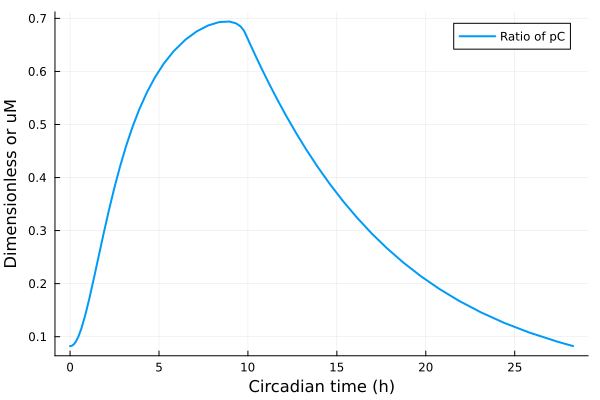

In [8]:
U0 = 3.5
X0 = [U0, 0, 0, 0, 0, 0]
A0 = 1.5
fATP = 1.0
p = [kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
     KA, A0, fATP, N, M]

_, _, Tbase, ϕbase = attracted_to(kaiabc_phong!, X0, 500.0, p, conv_tol=5e-3, avg_window=32)

prob = ODEProblem(kaiabc_phong!, X0, (0.0, 500.0), p)
sol = solve(prob, reltol=1e-8, abstol=1e-8)
pC = phospho_C(sol.u)

tstart = (2π - ϕbase)/2π*Tbase + 4*Tbase
ind = tstart .<= sol.t .<= tstart + Tbase
plot(sol.t[ind] .- tstart, pC[ind], xlabel="Circadian time (h)", ylabel="Dimensionless or uM", linewidth=2, label="Ratio of pC")

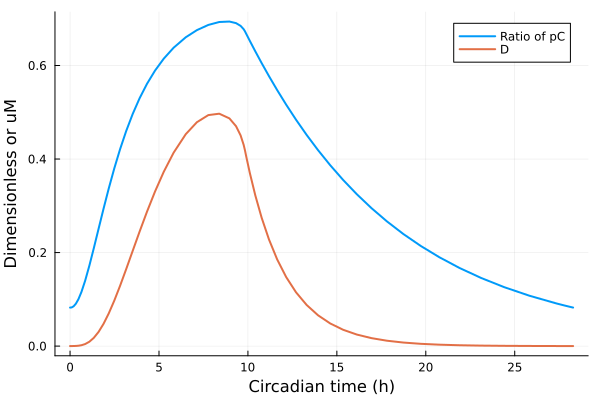

In [9]:
Xt = reduce(hcat, sol.u)
plot!(sol.t[ind] .- tstart, Xt[3, ind], linewidth=2, label="D")